# **Netflix Stock Price Prediction**

# **1. Data Understanding**

In [ ]:
#1.1 Load Data
# Import Libraries and Load Data
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime as dt

# Load historical stock price data
ticker = 'NFLX'
def fetch_historical_data(ticker, start_date):
    data = yf.download(ticker, start=start_date, end=dt.datetime.now().strftime('%Y-%m-%d'))
    data['Date'] = data.index
    return data

netflix_stock_data = fetch_historical_data(ticker, start_date='2010-01-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
#1.2 Explore Data
netflix_stock_data

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2010-01-04,7.931429,7.961429,7.565714,7.640000,7.640000,17239600,2010-01-04
2010-01-05,7.652857,7.657143,7.258571,7.358571,7.358571,23753100,2010-01-05
2010-01-06,7.361429,7.672857,7.197143,7.617143,7.617143,23290400,2010-01-06
2010-01-07,7.731429,7.757143,7.462857,7.485714,7.485714,9955400,2010-01-07
2010-01-08,7.498571,7.742857,7.465714,7.614286,7.614286,8180900,2010-01-08
...,...,...,...,...,...,...,...
2024-08-12,631.000000,639.000000,627.070007,633.140015,633.140015,2331700,2024-08-12
2024-08-13,638.559998,650.969971,635.500000,648.020020,648.020020,2639600,2024-08-13
2024-08-14,648.700012,663.570007,648.700012,661.679993,661.679993,4014300,2024-08-14


In [ ]:

netflix_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3680 entries, 2010-01-04 to 2024-08-16
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       3680 non-null   float64       
 1   High       3680 non-null   float64       
 2   Low        3680 non-null   float64       
 3   Close      3680 non-null   float64       
 4   Adj Close  3680 non-null   float64       
 5   Volume     3680 non-null   int64         
 6   Date       3680 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 230.0 KB


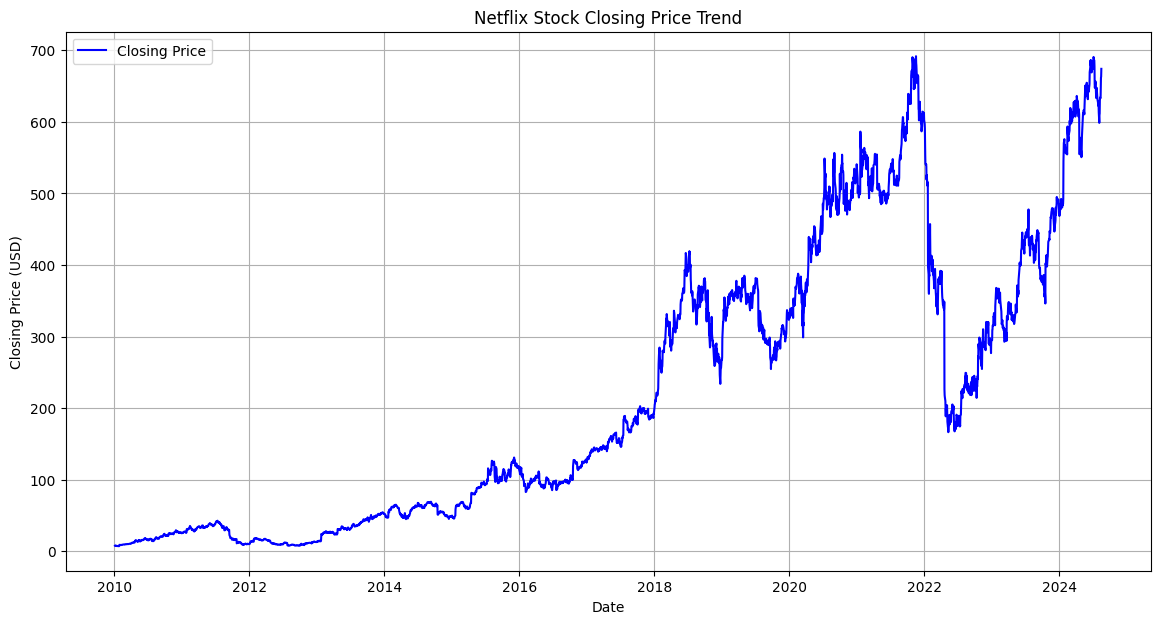

In [ ]:
#1.3 Visualize Data
import matplotlib.pyplot as plt

# Plot the closing price trendline
plt.figure(figsize=(14, 7))
plt.plot(netflix_stock_data['Date'], netflix_stock_data['Close'], color='blue', label='Closing Price')
plt.title('Netflix Stock Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Candle stick plot with moving average 20 and 30

import plotly.graph_objects as go

# Calculate moving averages
netflix_stock_data['MA20'] = netflix_stock_data['Close'].rolling(window=20).mean()
netflix_stock_data['MA30'] = netflix_stock_data['Close'].rolling(window=30).mean()

# Create candlestick trace
candlestick = go.Candlestick(x=netflix_stock_data['Date'],
                             open=netflix_stock_data['Open'],
                             high=netflix_stock_data['High'],
                             low=netflix_stock_data['Low'],
                             close=netflix_stock_data['Close'],
                             name='Candlestick')

# Create moving average traces
ma20 = go.Scatter(x=netflix_stock_data['Date'], y=netflix_stock_data['MA20'],
                 line=dict(color='blue', width=1), name='MA20')
ma30 = go.Scatter(x=netflix_stock_data['Date'], y=netflix_stock_data['MA30'],
                 line=dict(color='red', width=1), name='MA30')

# Create layout
layout = go.Layout(
    title={'text': 'Netflix Stock Price with Moving Averages', 'x': 0.5, 'xanchor': 'center'},
    xaxis_title='Date',
    yaxis_title='Price'
)
# Create figure and add traces
fig = go.Figure(data=[candlestick, ma20, ma30], layout=layout)

# Display the plot
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


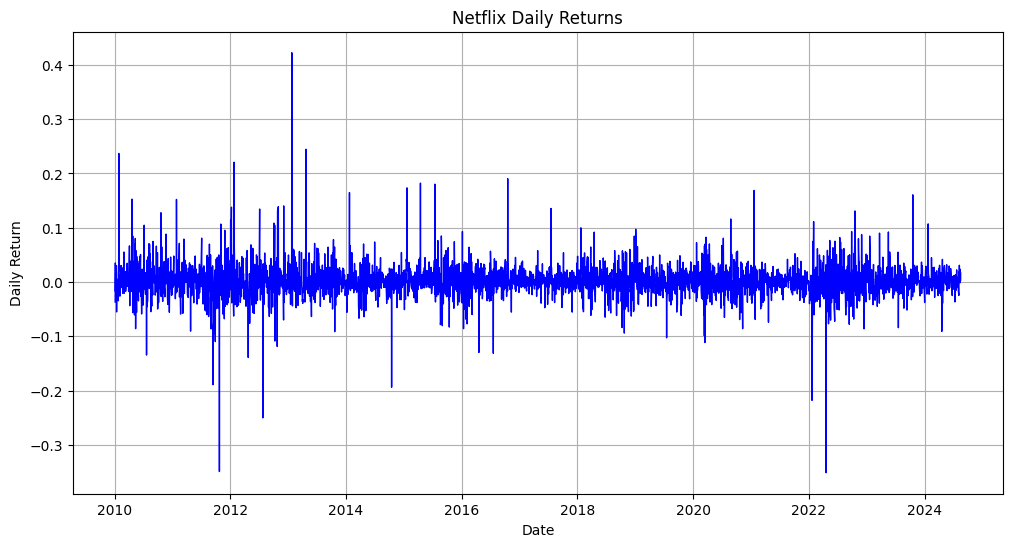

In [ ]:
# Calculate daily returns
netflix_stock_data['Daily Return'] = netflix_stock_data['Close'].pct_change()

# Plot the daily returns
plt.figure(figsize=(12, 6))
plt.plot(netflix_stock_data.index, netflix_stock_data['Daily Return'], color='blue', lw=1)
plt.title('Netflix Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()


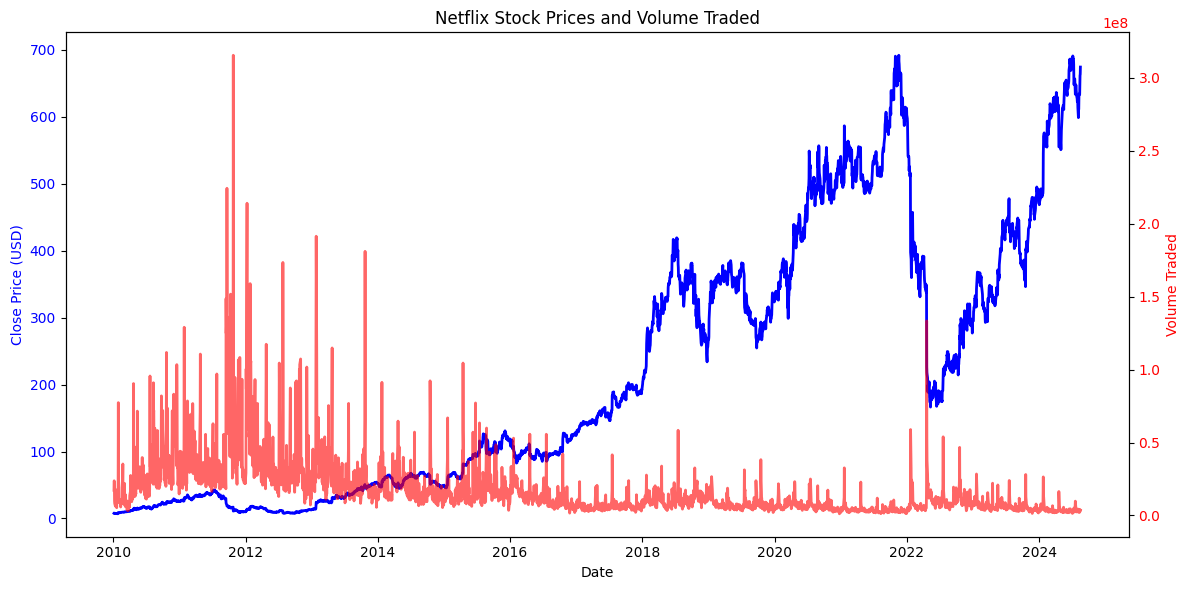

In [ ]:
# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the closing stock prices
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (USD)', color='blue')
ax1.plot(netflix_stock_data.index, netflix_stock_data['Close'], color='blue', lw=2)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot the trading volume
ax2 = ax1.twinx()
ax2.set_ylabel('Volume Traded', color='red')
ax2.plot(netflix_stock_data.index, netflix_stock_data['Volume'], color='red', lw=2, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Netflix Stock Prices and Volume Traded')

# Improve layout to avoid overlap
fig.tight_layout()

# Show the plot
plt.show()

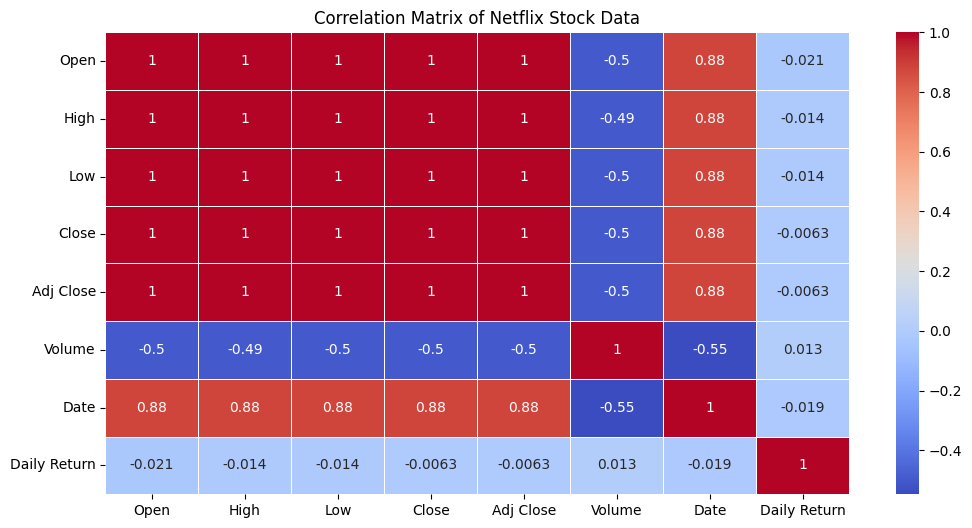

In [ ]:
import matplotlib.pyplot as plt
# Calculate the correlation matrix
correlation_matrix = netflix_stock_data.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Netflix Stock Data')
plt.show()

# **2. Data Preparation**

In [ ]:
# 2.1 Data Scaling
def scale_data(data):
    # Initialize MinMaxScaler to scale data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Scale the data using MinMaxScaler
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [ ]:
# 2.2 Feature Engineering - Create Datasets for LSTM/CNN
def create_dataset(data, time_step):
    X, y = [], []
    # Loop through the dataset and create sequences
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
# 2.3 Data Reshaping and Preparing Data for Modeling
def prepare_data(data, time_step=60):
    # Scale the data
    scaled_data, scaler = scale_data(data)

    # Create datasets using the scaled data
    X, y = create_dataset(scaled_data, time_step)

    # Reshape data into a 3D array for LSTM/CNN input
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y, scaler

In [ ]:
# 2.4 Applying the prepare_data Function
time_step = 60
X, y, scaler = prepare_data(netflix_stock_data[['Close']].values, time_step)

In [ ]:
print(X.shape)

(3627, 60, 1)


# **3. Modeling & Training**

In [ ]:
# Import the necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

# 3.1 Build & Train LSTM model
lstm_model = Sequential()
# Add Input layer
lstm_model.add(Input(shape=(time_step, 1)))
# Add LSTM layers
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50, return_sequences=False))
# Add Dense layers
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X, y, batch_size=1, epochs=1)

3625/3625 ━━━━━━━━━━━━━━━━━━━━ 89s 24ms/step - loss: 0.0023


In [ ]:
# Import the necessary libraries
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input

# 3.2 Build & Train CNN model
cnn_model = Sequential()
# Add Input layer
cnn_model.add(Input(shape=(time_step, 1)))
# Add Convolutional layers
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
# Add Flatten and Dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))
# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
cnn_model.fit(X, y, batch_size=1, epochs=1)

3625/3625 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0062


# **4. Evaluation**

In [ ]:
#4.1 Calculate Metrices
def evaluate_model(model, scaler, data, time_step):
    X, y = create_dataset(data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)
    y = scaler.inverse_transform([y])

    mse = mean_squared_error(y[0], predictions)
    rmse = np.sqrt(mse)
    return predictions, y[0], mse, rmse

# Scale the data for evaluation
scaled_data = scaler.transform(netflix_stock_data[['Close']].values)

# Evaluate LSTM model
lstm_predictions, actuals, lstm_mse, lstm_rmse = evaluate_model(lstm_model, scaler, scaled_data, time_step)

# Evaluate CNN model
cnn_predictions, _, cnn_mse, cnn_rmse = evaluate_model(cnn_model, scaler, scaled_data, time_step)

# Print metrics
print(f"LSTM Model - MSE: {lstm_mse}, RMSE: {lstm_rmse}")
print(f"CNN Model - MSE: {cnn_mse}, RMSE: {cnn_rmse}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Model - MSE: 276.7314382827901, RMSE: 16.635246865700253
CNN Model - MSE: 1439.4152661600046, RMSE: 37.93962659489422


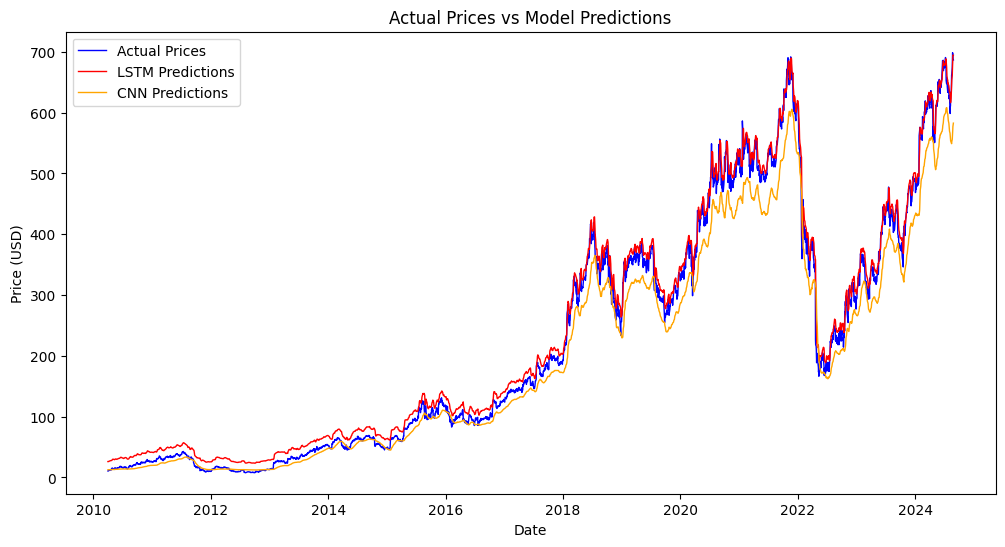

In [ ]:
#4.2 Visualize Results
# Create DataFrames for plotting
dates = netflix_stock_data.index[-len(lstm_predictions):]
results_df = pd.DataFrame({
    'Date': dates,
    'Actual': actuals,
    'LSTM_Predicted': lstm_predictions.flatten(),
    'CNN_Predicted': cnn_predictions.flatten()
})
plt.figure(figsize=(12, 6))

# Plot LSTM predictions
plt.plot(results_df['Date'], results_df['Actual'], label='Actual Prices', color='blue', linewidth=1)
plt.plot(results_df['Date'], results_df['LSTM_Predicted'], label='LSTM Predictions', color='red', linewidth=1)

# Plot CNN predictions
plt.plot(results_df['Date'], results_df['CNN_Predicted'], label='CNN Predictions', color='orange', linewidth=1)

plt.title('Actual Prices vs Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
results_df

,Date,Actual,LSTM_Predicted,CNN_Predicted
0,2010-04-01,10.534286,26.024382,12.524904
1,2010-04-05,10.714286,26.042604,12.532633
2,2010-04-06,11.427143,26.075090,12.543241
3,2010-04-07,11.910000,26.260719,12.551458
4,2010-04-08,11.390000,26.571119,12.568474
...,...,...,...,...
3620,2024-08-20,688.530029,668.936829,559.929260
3621,2024-08-21,698.539978,678.700745,564.290833
3622,2024-08-22,697.119995,688.687439,570.647644
3623,2024-08-23,688.960022,694.549133,576.947327


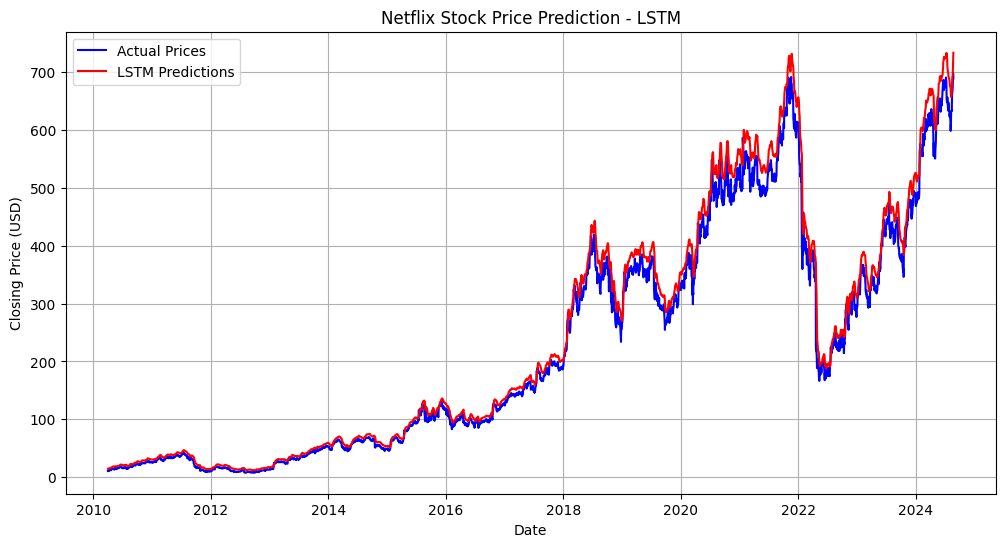

In [ ]:
import matplotlib.pyplot as plt

# Plot actual prices vs LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(netflix_stock_data['Date'].iloc[time_step+1:], actuals, color='blue', label='Actual Prices')
plt.plot(netflix_stock_data['Date'].iloc[time_step+1:], lstm_predictions, color='red', label='LSTM Predictions')
plt.title('Netflix Stock Price Prediction - LSTM')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


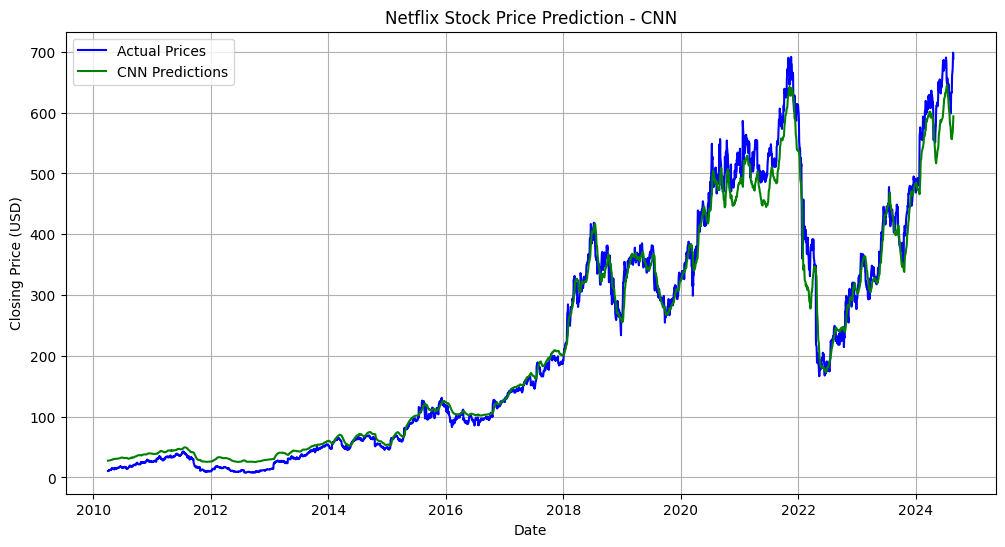

In [ ]:
import matplotlib.pyplot as plt

# Plot actual prices vs CNN predictions
plt.figure(figsize=(12, 6))
plt.plot(netflix_stock_data['Date'].iloc[time_step+1:], actuals, color='blue', label='Actual Prices')
plt.plot(netflix_stock_data['Date'].iloc[time_step+1:], cnn_predictions, color='green', label='CNN Predictions')
plt.title('Netflix Stock Price Prediction - CNN')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


# **5. Deployment - Real-Time Prediction (Optional)**

In [ ]:
import pandas as pd
import datetime as dt

#Data Loading
def real_time_prediction(model, scaler, ticker, time_step):
    # Fetch recent data
    recent_data = fetch_historical_data(ticker, start_date=(dt.datetime.now() - dt.timedelta(days=365)).strftime('%Y-%m-%d'))

#Data Preparation
    # Check if recent_data is empty or has missing values
    if recent_data.empty or recent_data['Close'].isnull().any():
        raise ValueError("Recent data is empty or contains missing values.")

    # Scale recent data
    recent_scaled_data = scaler.transform(recent_data[['Close']].values)

    # Create dataset for prediction
    X, _ = create_dataset(recent_scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)

#Modeling
    # Make predictions
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)

    # Create a DataFrame with dates and predictions
    recent_dates = recent_data.index[-len(predictions):]
    predictions_df = pd.DataFrame({
        'Date': recent_dates,
        'Actual': recent_data['Close'].values[-len(predictions):],
        'Prediction': predictions.flatten()
    })

    return predictions_df

#Evaluation
# Real-time predictions for LSTM and CNN models
try:
    # Check if models and scaler are properly loaded
    if lstm_model is None or cnn_model is None or scaler is None:
        raise ValueError("LSTM model, CNN model, or scaler is not loaded correctly.")

    # Generate predictions for LSTM and CNN models
    lstm_predictions = real_time_prediction(lstm_model, scaler, ticker, time_step)
    cnn_predictions = real_time_prediction(cnn_model, scaler, ticker, time_step)

    # Ensure the predictions have the same length before combining
    if len(lstm_predictions) != len(cnn_predictions):
        raise ValueError("LSTM and CNN predictions have different lengths.")

    # Combine LSTM and CNN predictions into a single DataFrame
    combined_predictions = pd.DataFrame({
        'Date': lstm_predictions['Date'],
        'Actual': lstm_predictions['Actual'],
        'LSTM_Prediction': lstm_predictions['Prediction'],
        'CNN_Prediction': cnn_predictions['Prediction']
    })

    # Save combined predictions to a single CSV file
    combined_predictions.to_csv('realtime_predictions.csv', index=False)

except Exception as e:
    print(f"Error during real-time prediction: {e}")

# Output the combined predictions DataFrame
combined_predictions

[*********************100%***********************]  1 of 1 completed

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[*********************100%***********************]  1 of 1 completed

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Date,Actual,LSTM_Prediction,CNN_Prediction
0,2023-11-22,478.000000,478.054840,392.206268
1,2023-11-24,479.559998,481.815460,396.485748
2,2023-11-27,479.170013,484.954987,400.051178
3,2023-11-28,479.000000,487.368561,403.508789
4,2023-11-29,477.190002,488.679840,406.485260
...,...,...,...,...
185,2024-08-20,698.539978,668.936829,559.929199
186,2024-08-21,697.119995,678.700745,564.290833
187,2024-08-22,688.960022,688.687378,570.647644
188,2024-08-23,686.729980,694.549133,576.947327


In [ ]:
# Combine the relevant data into a DataFrame
export_df = results_df[['Date', 'Actual', 'LSTM_Predicted', 'CNN_Predicted']]
export_df.to_csv('netflix_stock_predictions.csv', index=False)

results_df

,Date,Actual,LSTM_Predicted,CNN_Predicted
0,2010-04-01,10.534286,26.024382,12.524904
1,2010-04-05,10.714286,26.042604,12.532633
2,2010-04-06,11.427143,26.075090,12.543241
3,2010-04-07,11.910000,26.260719,12.551458
4,2010-04-08,11.390000,26.571119,12.568474
...,...,...,...,...
3620,2024-08-20,688.530029,668.936829,559.929260
3621,2024-08-21,698.539978,678.700745,564.290833
3622,2024-08-22,697.119995,688.687439,570.647644
3623,2024-08-23,688.960022,694.549133,576.947327


In [ ]:
# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN'],
    'MSE': [lstm_mse, cnn_mse],
    'RMSE': [lstm_rmse, cnn_rmse]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv('model_metrics.csv', index=False)

# **Netfix Subscriber Growth Rate Prediction**

# **1. Data Understanding**

In [ ]:
#1.1 Load Data
import pandas as pd

file_path = 'Netflix Userbase.csv'
subscriber_data = pd.read_csv(file_path)

In [ ]:
subscriber_data

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month
...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,25-07-22,12-07-23,Spain,28,Female,Smart TV,1 Month
2496,2497,Basic,15,04-08-22,14-07-23,Spain,33,Female,Smart TV,1 Month
2497,2498,Standard,12,09-08-22,15-07-23,United States,38,Male,Laptop,1 Month
2498,2499,Standard,13,12-08-22,12-07-23,Canada,48,Female,Tablet,1 Month


In [ ]:
#1.2 Explore Data
subscriber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User ID            2500 non-null   int64 
 1   Subscription Type  2500 non-null   object
 2   Monthly Revenue    2500 non-null   int64 
 3   Join Date          2500 non-null   object
 4   Last Payment Date  2500 non-null   object
 5   Country            2500 non-null   object
 6   Age                2500 non-null   int64 
 7   Gender             2500 non-null   object
 8   Device             2500 non-null   object
 9   Plan Duration      2500 non-null   object
dtypes: int64(3), object(7)
memory usage: 195.4+ KB


In [ ]:
# 1.3 Clean Data
# Define a function to convert dates to a standard format
def standardize_date_format(date_series, date_format):
    return pd.to_datetime(date_series, format=date_format, errors='coerce')

# Detect and standardize date formats
subscriber_data['Join Date'] = standardize_date_format(subscriber_data['Join Date'], '%d-%m-%y')
subscriber_data['Last Payment Date'] = standardize_date_format(subscriber_data['Last Payment Date'], '%d-%m-%y')

# Drop rows with invalid dates if any
subscriber_data.dropna(subset=['Join Date', 'Last Payment Date'], inplace=True)

subscriber_data.to_csv('cleaned_subscriber_data.csv', index=False)
subscriber_data

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,2022-01-15,2023-06-10,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,2021-09-05,2023-06-22,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,2022-07-10,2023-06-26,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,2023-05-01,2023-06-28,Germany,33,Male,Smartphone,1 Month
...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,2022-07-25,2023-07-12,Spain,28,Female,Smart TV,1 Month
2496,2497,Basic,15,2022-08-04,2023-07-14,Spain,33,Female,Smart TV,1 Month
2497,2498,Standard,12,2022-08-09,2023-07-15,United States,38,Male,Laptop,1 Month
2498,2499,Standard,13,2022-08-12,2023-07-12,Canada,48,Female,Tablet,1 Month


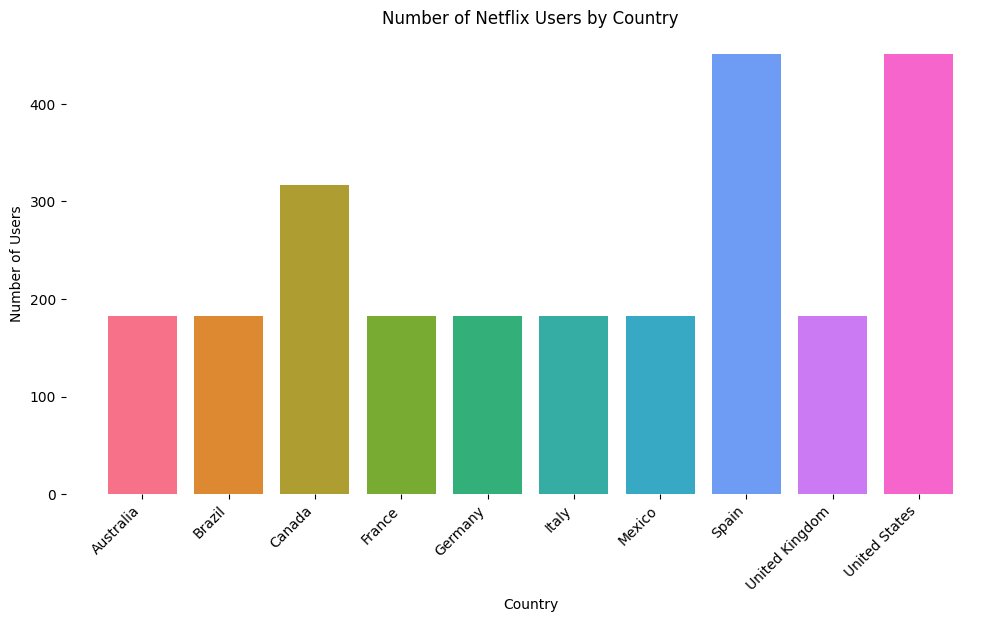

In [ ]:
#1.4 Visualize Data
import matplotlib.pyplot as plt
import seaborn as sns
# Group by 'Country' and count the number of users
users_by_country = subscriber_data.groupby('Country').size().reset_index(name='Number of Users')

# Generate a color palette
colors = sns.color_palette('husl', len(users_by_country))

# Plot the data with different colors for each country
plt.figure(figsize=(12, 6))
plt.bar(users_by_country['Country'], users_by_country['Number of Users'], color=colors)
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title('Number of Netflix Users by Country')
plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
sns.despine(left=True, bottom=True)
# Display the plot
plt.show()

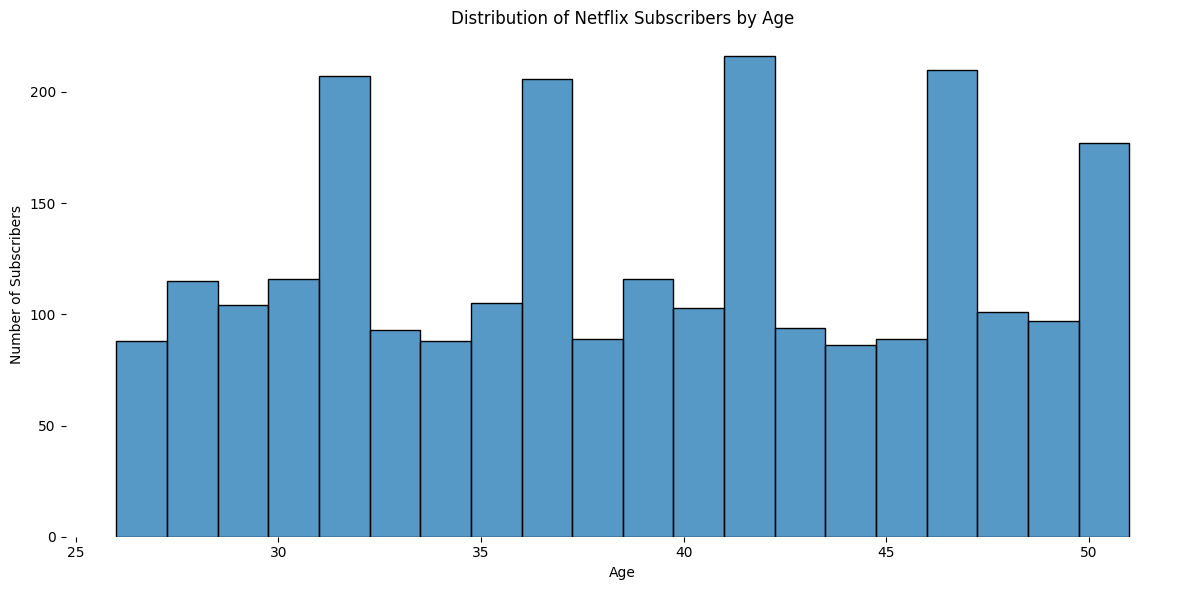

In [ ]:
# Plotting the distribution of subscribers by age
plt.figure(figsize=(12, 6))

# Histogram
sns.histplot(subscriber_data['Age'], kde=False, bins=20)
plt.xlabel('Age')
plt.ylabel('Number of Subscribers')
plt.title('Distribution of Netflix Subscribers by Age')
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.show()

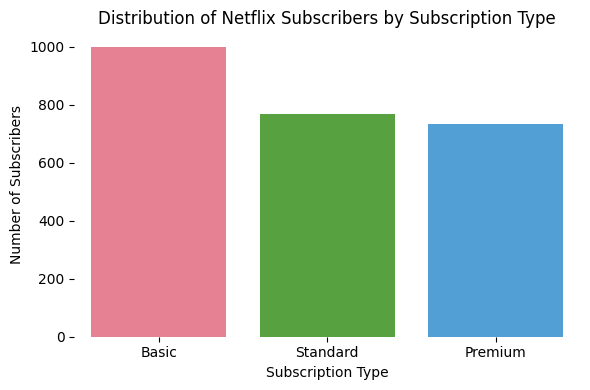

In [ ]:
# Count the number of subscribers for each subscription type
subscription_type_distribution = subscriber_data['Subscription Type'].value_counts().reset_index()
subscription_type_distribution.columns = ['Subscription Type', 'Number of Subscribers']
# Plot the distribution of subscription types with the hue set to the x variable
plt.figure(figsize=(6, 4))
sns.barplot(x='Subscription Type', y='Number of Subscribers', data=subscription_type_distribution, hue='Subscription Type', palette='husl', dodge=False, legend=False)
plt.xlabel('Subscription Type')
plt.ylabel('Number of Subscribers')
plt.title('Distribution of Netflix Subscribers by Subscription Type')
plt.tight_layout()
sns.despine(left=True, bottom=True)

# Display the plot
plt.show()

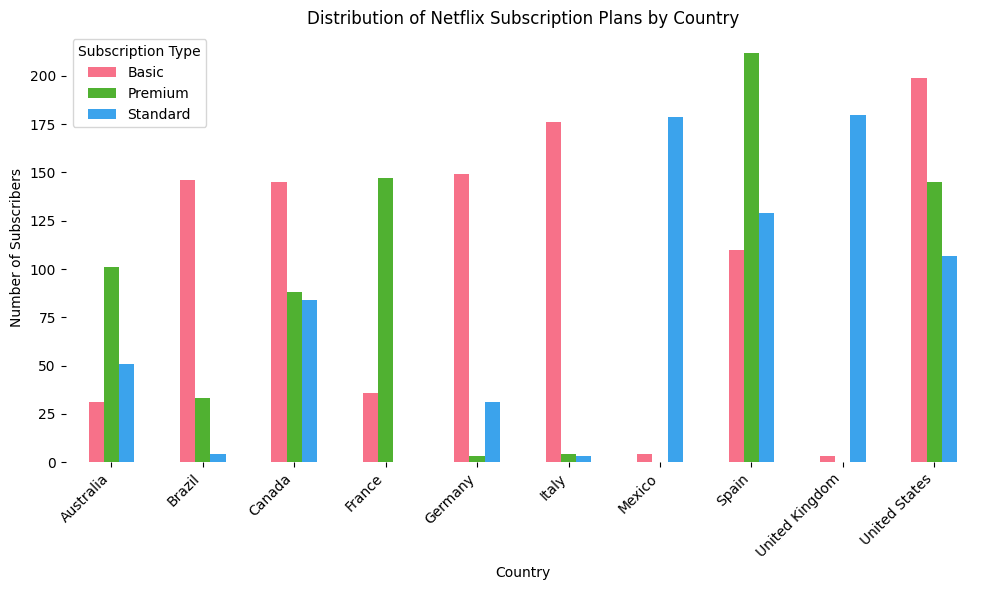

In [ ]:
# Count the number of subscribers for each subscription type in each country
subscription_by_country = subscriber_data.groupby(['Country', 'Subscription Type']).size().unstack(fill_value=0)

# Define a consistent color palette for subscription types
colors = sns.color_palette('husl', len(subscription_by_country.columns))

# Plot the grouped bar chart
subscription_by_country.plot(kind='bar', figsize=(10, 6), color=colors)

# Add labels and title
plt.xlabel('Country')
plt.ylabel('Number of Subscribers')
plt.title('Distribution of Netflix Subscription Plans by Country')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Subscription Type')
plt.tight_layout()
sns.despine(left=True, bottom=True)

# Display the plot
plt.show()

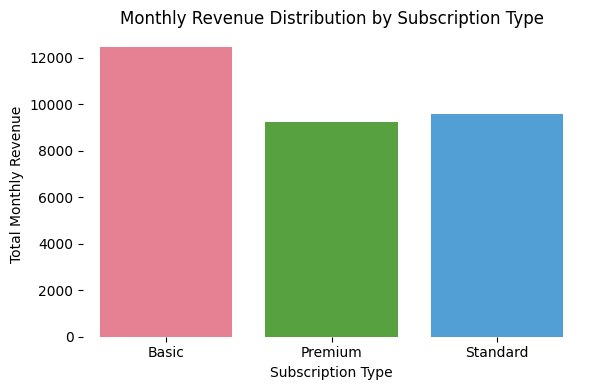

In [ ]:
# Calculate the total monthly revenue for each subscription type
revenue_by_subscription = subscriber_data.groupby('Subscription Type')['Monthly Revenue'].sum().reset_index()

# Plot the revenue distribution by subscription type
plt.figure(figsize=(6, 4))
sns.barplot(x='Subscription Type', y='Monthly Revenue', data=revenue_by_subscription, hue='Subscription Type', palette='husl', dodge=False, legend=False)
plt.xlabel('Subscription Type')
plt.ylabel('Total Monthly Revenue')
plt.title('Monthly Revenue Distribution by Subscription Type')
plt.tight_layout()
sns.despine(left=True, bottom=True)

# Display the plot
plt.show()

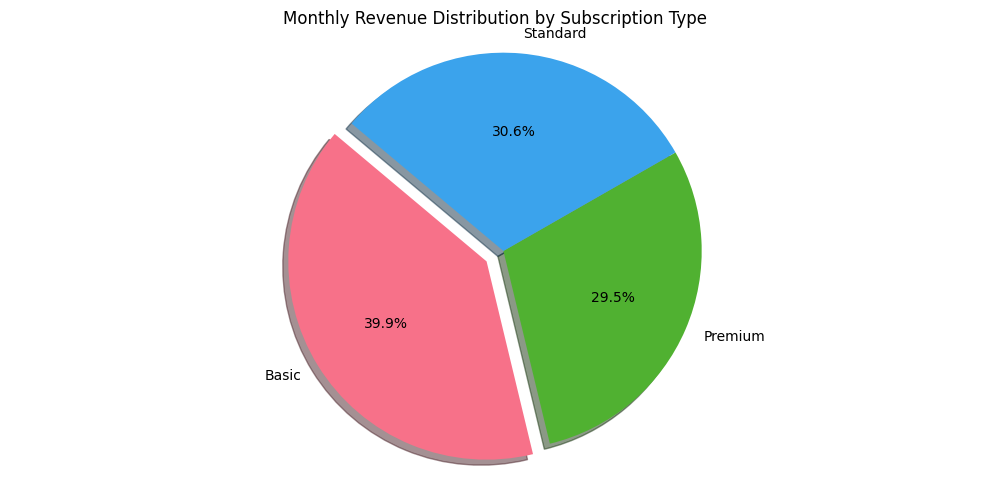

In [ ]:
import matplotlib.pyplot as plt

# Calculate the total monthly revenue for each subscription type
revenue_by_subscription = subscriber_data.groupby('Subscription Type')['Monthly Revenue'].sum().reset_index()

# Plot the revenue distribution by subscription type as a pie chart
plt.figure(figsize=(10, 5))

# Extracting data for plotting
labels = revenue_by_subscription['Subscription Type']
sizes = revenue_by_subscription['Monthly Revenue']
explode = (0.1,) + (0,) * (len(labels) - 1)  # Explode the first slice for emphasis

# Plot the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Monthly Revenue Distribution by Subscription Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.tight_layout()
plt.show()

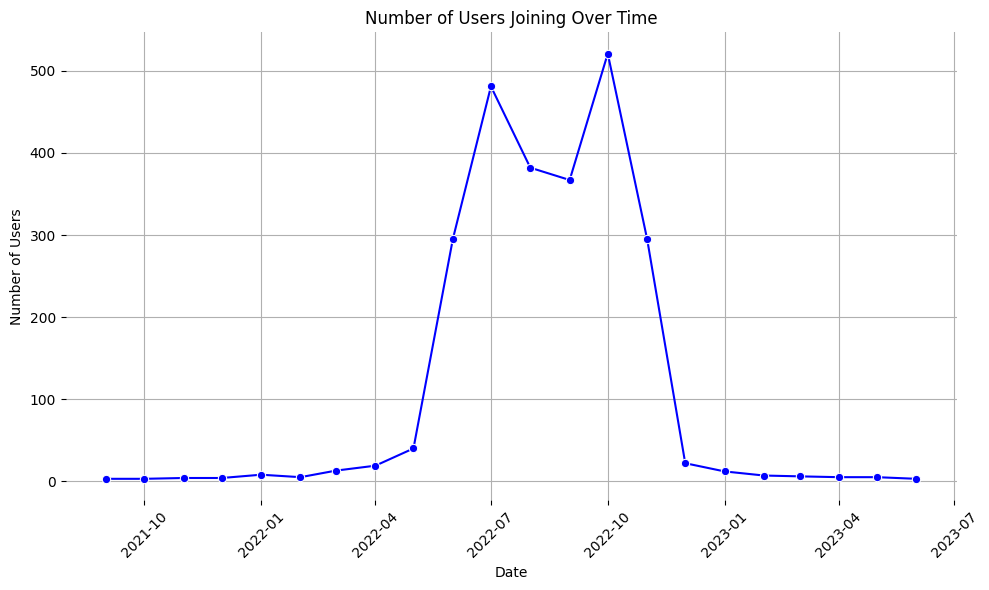

In [ ]:
# Convert 'Join Date' to datetime format
subscriber_data['Join Date'] = pd.to_datetime(subscriber_data['Join Date'])
# Extract month and year for aggregation
subscriber_data['Year-Month'] = subscriber_data['Join Date'].dt.to_period('M')

# Count number of users joining per month
monthly_join_counts = subscriber_data.groupby('Year-Month').size().reset_index(name='Number of Users')
# Plotting the trend of new users joining over time
plt.figure(figsize=(10, 6))

# Convert 'Year-Month' back to datetime for plotting
monthly_join_counts['Year-Month'] = monthly_join_counts['Year-Month'].dt.to_timestamp()

sns.lineplot(x='Year-Month', y='Number of Users', data=monthly_join_counts, marker='o', linestyle='-', color='b')

plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.title('Number of Users Joining Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
sns.despine(left=True, bottom=True)
# Display the plot
plt.show()

In [ ]:
subscriber_data

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration,Year-Month
0,1,Basic,10,2022-01-15,2023-06-10,United States,28,Male,Smartphone,1 Month,2022-01
1,2,Premium,15,2021-09-05,2023-06-22,Canada,35,Female,Tablet,1 Month,2021-09
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1 Month,2023-02
3,4,Standard,12,2022-07-10,2023-06-26,Australia,51,Female,Laptop,1 Month,2022-07
4,5,Basic,10,2023-05-01,2023-06-28,Germany,33,Male,Smartphone,1 Month,2023-05
...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,2022-07-25,2023-07-12,Spain,28,Female,Smart TV,1 Month,2022-07
2496,2497,Basic,15,2022-08-04,2023-07-14,Spain,33,Female,Smart TV,1 Month,2022-08
2497,2498,Standard,12,2022-08-09,2023-07-15,United States,38,Male,Laptop,1 Month,2022-08
2498,2499,Standard,13,2022-08-12,2023-07-12,Canada,48,Female,Tablet,1 Month,2022-08


# **2. Data Preparation**

In [ ]:
#2.1 Feature Engineering

# Create new columns for Year, Quarter, Month, and Day
subscriber_data['Year'] = subscriber_data['Join Date'].dt.year
subscriber_data['Quarter'] = subscriber_data['Join Date'].dt.to_period('Q').astype(str)
subscriber_data['Month'] = subscriber_data['Join Date'].dt.to_period('M').astype(str)
subscriber_data['Day'] = subscriber_data['Join Date'].dt.date

# Calculate Monthly Subscriber Count and Growth Rate
monthly_subscriber_count = subscriber_data.groupby(['Country', 'Month']).size().reset_index(name='Monthly Subscriber Count')
# Merge the subscriber count back into the original DataFrame
subscriber_data = pd.merge(subscriber_data, monthly_subscriber_count, on=['Country', 'Month'], how='left')

# Calculate Growth Rate (%) per region and month
monthly_subscriber_count['Growth Rate (%)'] = monthly_subscriber_count.groupby('Country')['Monthly Subscriber Count'].pct_change().fillna(0) * 100
# Merge the growth rate back into the original DataFrame
subscriber_data = pd.merge(subscriber_data, monthly_subscriber_count[['Country', 'Month', 'Growth Rate (%)']], on=['Country', 'Month'], how='left')

# Save the updated DataFrame to a CSV file
subscriber_data.to_csv('subscriber_data_with_growth_rates.csv', index=False)
subscriber_data

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration,Year,Quarter,Month,Day,Monthly Subscriber Count,Growth Rate (%)
0,1,Basic,10,2022-01-15,2023-06-10,United States,28,Male,Smartphone,1 Month,2022,2022Q1,2022-01,2022-01-15,2,0.000000
1,2,Premium,15,2021-09-05,2023-06-22,Canada,35,Female,Tablet,1 Month,2021,2021Q3,2021-09,2021-09-05,1,0.000000
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1 Month,2023,2023Q1,2023-02,2023-02-28,1,0.000000
3,4,Standard,12,2022-07-10,2023-06-26,Australia,51,Female,Laptop,1 Month,2022,2022Q3,2022-07,2022-07-10,35,66.666667
4,5,Basic,10,2023-05-01,2023-06-28,Germany,33,Male,Smartphone,1 Month,2023,2023Q2,2023-05,2023-05-01,2,-33.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,2022-07-25,2023-07-12,Spain,28,Female,Smart TV,1 Month,2022,2022Q3,2022-07,2022-07-25,85,70.000000
2496,2497,Basic,15,2022-08-04,2023-07-14,Spain,33,Female,Smart TV,1 Month,2022,2022Q3,2022-08,2022-08-04,72,-15.294118
2497,2498,Standard,12,2022-08-09,2023-07-15,United States,38,Male,Laptop,1 Month,2022,2022Q3,2022-08,2022-08-09,69,-22.471910
2498,2499,Standard,13,2022-08-12,2023-07-12,Canada,48,Female,Tablet,1 Month,2022,2022Q3,2022-08,2022-08-12,47,-27.692308


In [ ]:
#2.2 Encode Categories
from sklearn.preprocessing import LabelEncoder

# Create a copy of the relevant columns for encoding
data_for_encoding = subscriber_data[['Country', 'Subscription Type', 'Gender', 'Device', 'Plan Duration']].copy()

# Initialize a dictionary to hold label encoders
label_encoders = {}

# Apply LabelEncoder to each categorical column
for column in data_for_encoding.columns:
    le = LabelEncoder()
    data_for_encoding[column] = le.fit_transform(data_for_encoding[column]) +1
    label_encoders[column] = le

# Combine the encoded data with the original DataFrame
subscriber_data_encoded = subscriber_data.copy()
subscriber_data_encoded[data_for_encoding.columns] = data_for_encoding

subscriber_data_encoded

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration,Year,Quarter,Month,Day,Monthly Subscriber Count,Growth Rate (%)
0,1,1,10,2022-01-15,2023-06-10,10,28,2,3,1,2022,2022Q1,2022-01,2022-01-15,2,0.000000
1,2,2,15,2021-09-05,2023-06-22,3,35,1,4,1,2021,2021Q3,2021-09,2021-09-05,1,0.000000
2,3,3,12,2023-02-28,2023-06-27,9,42,2,2,1,2023,2023Q1,2023-02,2023-02-28,1,0.000000
3,4,3,12,2022-07-10,2023-06-26,1,51,1,1,1,2022,2022Q3,2022-07,2022-07-10,35,66.666667
4,5,1,10,2023-05-01,2023-06-28,5,33,2,3,1,2023,2023Q2,2023-05,2023-05-01,2,-33.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,2,14,2022-07-25,2023-07-12,8,28,1,2,1,2022,2022Q3,2022-07,2022-07-25,85,70.000000
2496,2497,1,15,2022-08-04,2023-07-14,8,33,1,2,1,2022,2022Q3,2022-08,2022-08-04,72,-15.294118
2497,2498,3,12,2022-08-09,2023-07-15,10,38,2,1,1,2022,2022Q3,2022-08,2022-08-09,69,-22.471910
2498,2499,3,13,2022-08-12,2023-07-12,3,48,1,4,1,2022,2022Q3,2022-08,2022-08-12,47,-27.692308


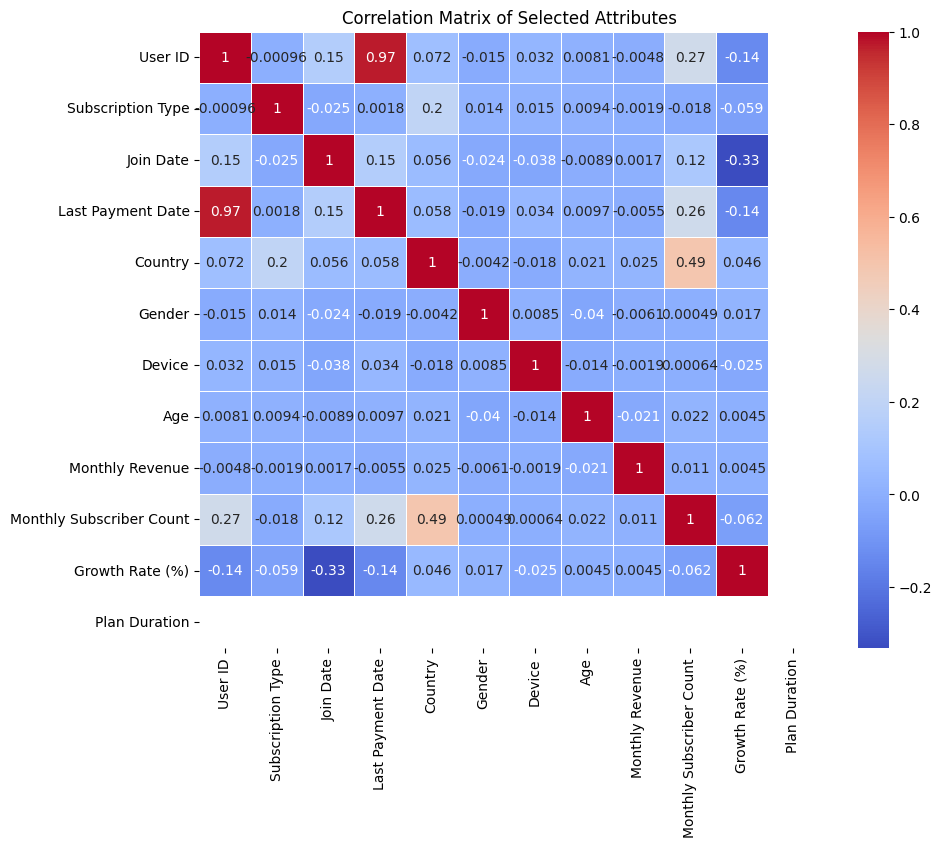

In [ ]:
#2.3 correlation matrix

import matplotlib.pyplot as plt
import seaborn as sns
# Select relevant attributes for correlation analysis
attributes = ['User ID', 'Subscription Type', 'Join Date', 'Last Payment Date', 'Country', 'Gender', 'Device', 'Age', 'Monthly Revenue', 'Monthly Subscriber Count',
              'Growth Rate (%)', 'Plan Duration']

# Extract the selected attributes from the encoded DataFrame
selected_data = subscriber_data_encoded[attributes]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Selected Attributes')
plt.show()

In [ ]:
# Calculate correlations with 'Growth Rate (%)'
correlations = correlation_matrix['Growth Rate (%)'].sort_values(ascending=False)

# Print correlations in descending order
correlations

,Growth Rate (%)
Growth Rate (%),1.000000
Country,0.045854
Gender,0.017306
Age,0.004507
Monthly Revenue,0.004462
Device,-0.024586
Subscription Type,-0.058909
Monthly Subscriber Count,-0.061929
User ID,-0.136552
Last Payment Date,-0.140974


In [ ]:
#2.3 Feature Selection
# Define features and target variable
features = subscriber_data_encoded[['Country', 'Subscription Type', 'Monthly Revenue',
                                    'Age', 'Gender', 'Device', 'Monthly Subscriber Count']]
target = subscriber_data_encoded['Growth Rate (%)']

In [ ]:
# 2.4 Data Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# **3. Modeling & Training**

In [ ]:
#3.1 Train Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# **4. Evaluation**

In [ ]:
#4.1 Make Predictions
# Make predictions
y_pred = rf_model.predict(X_test)

# Add country names to the test set
test_data = subscriber_data.loc[X_test.index].copy()

# Add predictions and actual growth rates to the test data
test_data['Actual Growth Rate'] = y_test.values
test_data['Predicted Growth Rate'] = y_pred

# Create a DataFrame with relevant columns
result_df = test_data[['Country', 'Actual Growth Rate', 'Predicted Growth Rate']]
result_df

,Country,Actual Growth Rate,Predicted Growth Rate
1447,United States,53.448276,53.448276
1114,Italy,51.851852,51.511895
1064,Germany,60.869565,62.402330
2287,United States,-22.471910,-22.471910
1537,United States,48.484848,48.484848
...,...,...,...
2375,Spain,68.750000,68.750000
1609,Italy,51.851852,51.292089
596,Canada,1000.000000,1000.000000
84,Germany,50.000000,33.967857


In [ ]:
# aggregate result_df data by countries name

# Group the data by 'Country' and calculate the mean of 'Actual Growth Rate' and 'Predicted Growth Rate'
result_df.groupby('Country').agg({'Actual Growth Rate': 'mean', 'Predicted Growth Rate': 'mean'})


,Actual Growth Rate,Predicted Growth Rate
Country,,
Australia,36.375273,33.529525
Brazil,204.232860,206.623033
Canada,174.291666,179.119307
France,78.114296,68.621368
Germany,31.315892,53.430535
Italy,141.130711,142.079715
Mexico,150.862166,136.462910
Spain,12.915315,14.789215
United Kingdom,52.648362,54.398247


In [ ]:
#4.2 Calculate Metrices
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Evaluate Performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'R-squared (R²): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

R-squared (R²): 0.9881422562300776
Root Mean Squared Error (RMSE): 40.341891586064534


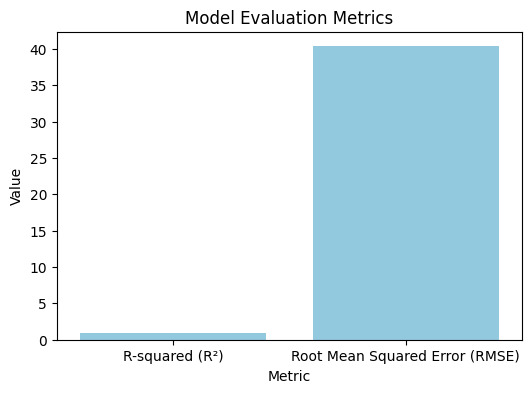

In [ ]:
# Generate plot for R2 and RMSE

import pandas as pd
import matplotlib.pyplot as plt
# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['R-squared (R²)', 'Root Mean Squared Error (RMSE)'],
    'Value': [r2, rmse]
})

# Plot the metrics
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Value', data=metrics_df, color='skyblue')
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')
plt.show()


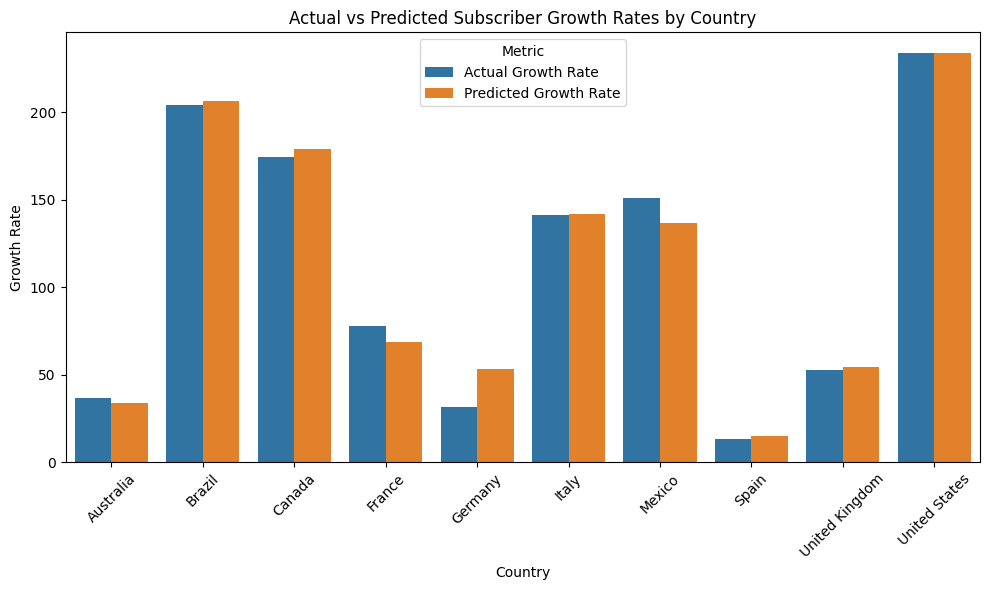

In [ ]:
#4.3 Visualize Results
import matplotlib.pyplot as plt
import seaborn as sns

# Plot predictions vs. actual values
aggregated_data = result_df.groupby('Country').agg({
    'Actual Growth Rate': 'mean',
    'Predicted Growth Rate': 'mean'
}).reset_index()

# Melt the DataFrame to have a long-form DataFrame suitable for seaborn
df_melted = aggregated_data.melt(id_vars='Country', var_name='Metric', value_name='Growth Rate')

plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Growth Rate', hue='Metric', data=df_melted)
plt.title('Actual vs Predicted Subscriber Growth Rates by Country')
plt.xlabel('Country')
plt.ylabel('Growth Rate')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

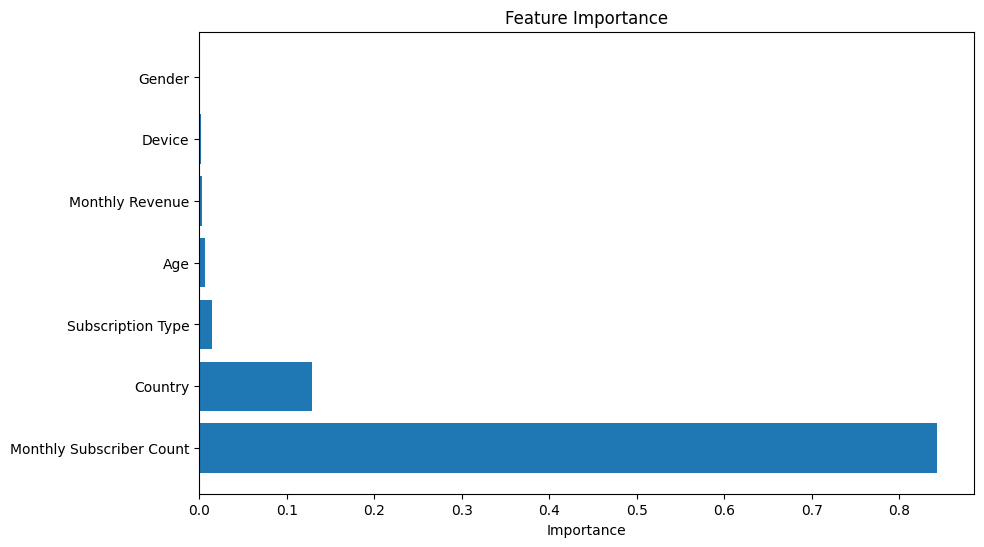

In [ ]:
# Feature importance from the Random Forest model
importances = rf_model.feature_importances_
feature_names = features.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

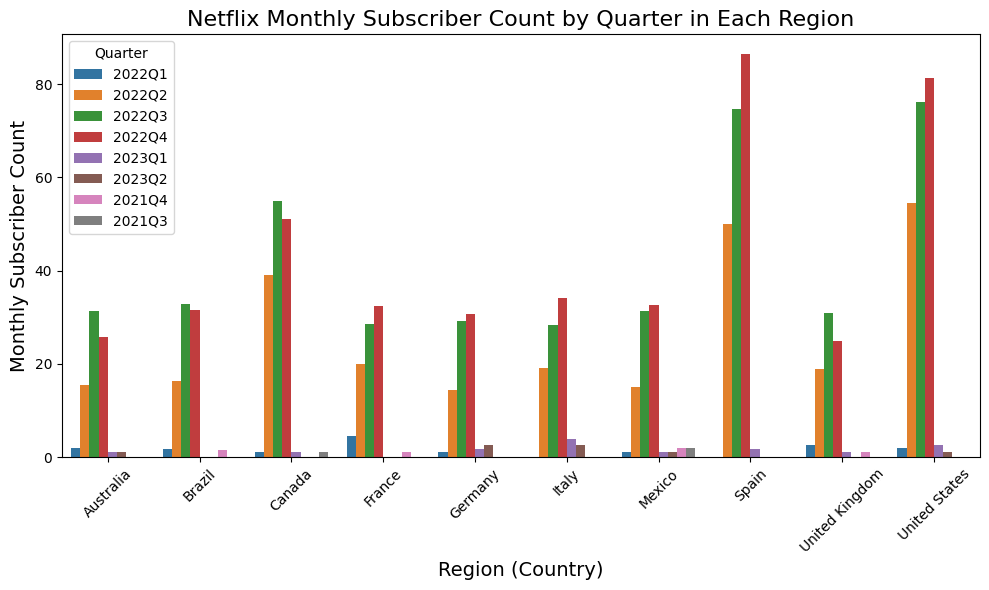

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'subscriber_data' and 'quarterly_data' have already been defined

# Aggregate data to get the average monthly subscriber count per quarter by country
monthly_data = subscriber_data.groupby(['Country', 'Quarter']).agg({
    'Monthly Subscriber Count': 'mean'
}).reset_index()

# Plotting the bar graph
plt.figure(figsize=(10, 6))

# Using seaborn to create a bar plot
sns.barplot(data=monthly_data, x='Country', y='Monthly Subscriber Count', hue='Quarter')

# Adding titles and labels for clarity
plt.title('Netflix Monthly Subscriber Count by Quarter in Each Region', fontsize=16)
plt.xlabel('Region (Country)', fontsize=14)
plt.ylabel('Monthly Subscriber Count', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# View trends by region
region_trends = subscriber_data.groupby('Country').agg({
    'Monthly Subscriber Count': 'mean',
    'Growth Rate (%)': 'mean'
}).reset_index()

# Print regional trends
region_trends

,Country,Monthly Subscriber Count,Growth Rate (%)
0,Australia,26.169399,36.914877
1,Brazil,29.338798,190.756428
2,Canada,50.488959,146.449223
3,France,26.803279,80.796826
4,Germany,25.535519,39.903514
5,Italy,27.743169,235.395787
6,Mexico,28.879781,158.212350
7,Spain,75.660754,17.542410
8,United Kingdom,25.524590,46.364269
9,United States,73.567627,248.086396


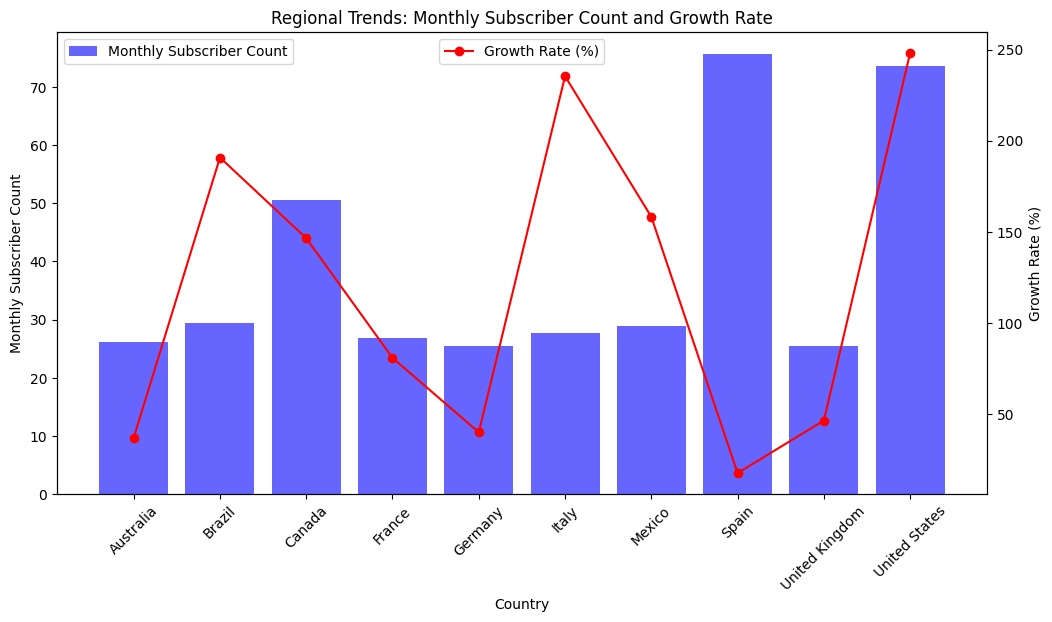

In [ ]:
# Plot regional trends
plt.figure(figsize=(12, 6))
plt.bar(region_trends['Country'], region_trends['Monthly Subscriber Count'], color='blue', alpha=0.6, label='Monthly Subscriber Count')
plt.xlabel('Country')
plt.ylabel('Monthly Subscriber Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.twinx()
plt.plot(region_trends['Country'], region_trends['Growth Rate (%)'], color='red', marker='o', label='Growth Rate (%)')
plt.ylabel('Growth Rate (%)')
plt.legend(loc='upper center')


plt.title('Regional Trends: Monthly Subscriber Count and Growth Rate')
plt.show()

# **5. Deployment**

In [ ]:
import pandas as pd

# Save predictions and actual values to a CSV file
result_df.to_csv('subscriber_growth_predictions.csv', index=False)

# Save the subscriber data with growth rates to a separate CSV file
subscriber_data.to_csv('subscriber_data_with_growth_rates.csv', index=False)

print("Files have been saved successfully and are ready for Power BI integration.")

Files have been saved successfully and are ready for Power BI integration.


In [ ]:
# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['R-squared (R²)', 'Root Mean Squared Error (RMSE)'],
    'Value': [r2, rmse]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv('subscriber_metrics.csv', index=False)

In [ ]:
# Save the feature importance to a CSV file
feature_importance_df.to_csv('feature_importance.csv', index=True)

In [ ]:
correlation_matrix.to_csv('correlation_matrix.csv', index=True)